In [1]:
import librosa
import soundfile
import os
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.models import Model
from keras.layers import (
    Conv1D,
    Activation,
    Dropout,
    MaxPooling1D,
    Flatten,
    Dense,
    Input,
)
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [2]:
# Function to recursively get all audio files from a directory
def get_audio_files(base_path):
    audio_files = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(".wav"):
                audio_files.append(os.path.join(root, file))
    return audio_files


# Base path for TESS dataset
base_path_TESS = "../data/raw/TESS_Toronto_emotional_speech_set_data"

# Get all audio files from TESS datasets
audio_files_tess = get_audio_files(base_path_TESS)
# Save audio files paths
if not os.path.exists("../data/processed/audio_files_tess.txt"):
    with open("../data/processed/audio_files_tess.txt", "w") as f:
        for item in audio_files_tess:
            f.write("%s\n" % item)
    print("../data/processed/audio_files_tess.txt already exists is created")
else:
    print("../data/processed/audio_files_tess.txt already exists")

../data/processed/audio_files_tess.txt already exists


In [4]:
# Function to extract mfcc, chroma, mel, and contrast features from audio files
def extract_features(file_path, sample_rate=22050):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        features = np.hstack(
            (
                np.mean(mfccs, axis=1),
                np.mean(chroma, axis=1),
                np.mean(mel, axis=1),
                np.mean(contrast, axis=1),
            )
        )
        return features
    except Exception:
        print(f"Error encountered while parsing file: {file_path}")
        return None


# Load audio files from the text file
audio_files_tess = []
with open("../data/processed/audio_files_tess.txt", "r") as file:
    audio_files_tess = [line.strip() for line in file.readlines()]

# Extract features from all audio files
features_tess = []
labels_tess = []
label_map_tess = {
    "OAF_angry": 4,
    "OAF_disgust": 6,
    "OAF_Fear": 5,
    "OAF_happy": 2,
    "OAF_Pleasant_surprise": 7,
    "OAF_Sad": 3,
    "OAF_neutral": 0,
    "YAF_angry": 4,
    "YAF_disgust": 6,
    "YAF_fear": 5,
    "YAF_happy": 2,
    "YAF_pleasant_surprised": 7,
    "YAF_sad": 3,
    "YAF_neutral": 0,
}
label_map_ravdess = {
    "01": 0,
    "02": 1,
    "03": 2,
    "04": 3,
    "05": 4,
    "06": 5,
    "07": 6,
    "08": 7,
}
if not os.path.exists("../data/processed/features.npy"):
    for idx, file in enumerate(audio_files_tess, start=1):
        feature = extract_features(file)
        if feature is not None:
            features_tess.append(feature)
            if "audio_speech_actors_01-24" in file:
                # Extract label from RAVDESS file name
                label = file.split(os.sep)[-1].split("-")[2]
                labels_tess.append(label_map_ravdess[label])
            else:
                # Extract label from TESS file path
                emotion = file.split(os.sep)[-2]
                if emotion in label_map_tess:
                    labels_tess.append(label_map_tess[emotion])
                else:
                    print(f"Skipping {file} with unrecognized emotion: {emotion}")
                    features_tess.pop()  # Remove the feature if label is not recognized
            print(f"Processing file {idx} of {len(audio_files_tess)}")

    print("Feature extraction complete.")
    features_tess = np.array(features_tess)
    np.save("../data/processed/features_tess.npy", features_tess)
    labels_tess = np.array(labels_tess)
    np.save("../data/processed/labels_tess.npy", labels_tess)
else:
    # Load features and labels
    features_tess = np.load("../data/processed/features_tess.npy")
    labels_tess = np.load("../data/processed/labels_tess.npy")
    print("loaded")

loaded


In [5]:
# Convert the features and labels into numpy arrays
X = np.array(features_tess)
y = np.array(labels_tess)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Reshape data to fit the model: (num_samples, timesteps, num_features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [6]:
# Initialize a sequential model
model = Sequential()

# First convolutional layer with 64 filters, kernel size 5, 'same' padding, and ReLU activation
# Input shape is (num_features, 1)
model.add(
    Conv1D(64, 5, padding="same", input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Second convolutional layer with 128 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(128, 5, padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Third convolutional layer with 256 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(256, 5, padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.1))

# Flatten the output for the dense layer
model.add(Flatten())

# Dense layer with 8 units and softmax activation for multi-class classification
model.add(Dense(8))
model.add(Activation("softmax"))

# Define the RMSprop optimizer with a lower learning rate
opt = RMSprop(learning_rate=0.001)

# Compile the model with categorical crossentropy loss and the defined optimizer
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

# Print a summary of the model architecture
model.summary()

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 46, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        22,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,104 (891.03 KB)

 Trainable params: 228,104 (891.03 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile the model with sparse categorical crossentropy loss and the defined optimizer
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [8]:
# Ensure X_train and X_test are reshaped correctly
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4404 - loss: 4.6999 - val_accuracy: 0.7714 - val_loss: 0.5390
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8490 - loss: 0.3978 - val_accuracy: 0.9464 - val_loss: 0.1980
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9485 - loss: 0.1437 - val_accuracy: 0.9839 - val_loss: 0.0795
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9534 - loss: 0.1446 - val_accuracy: 0.9607 - val_loss: 0.1262
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9561 - loss: 0.1300 - val_accuracy: 0.9750 - val_loss: 0.1107
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9750 - loss: 0.0718 - val_accuracy: 0.9893 - val_loss: 0.0484
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9834 - loss: 0.0447 - val_accuracy: 0.9804 - val_loss: 0.1192
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9851 - loss: 0.0512 - val_accuracy: 0.9750 - val_

Test accuracy: 0.9928571581840515
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           2       0.98      1.00      0.99        80
           3       1.00      1.00      1.00        80
           4       1.00      1.00      1.00        80
           5       1.00      0.96      0.98        80
           6       0.98      1.00      0.99        80
           7       1.00      0.99      0.99        80

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



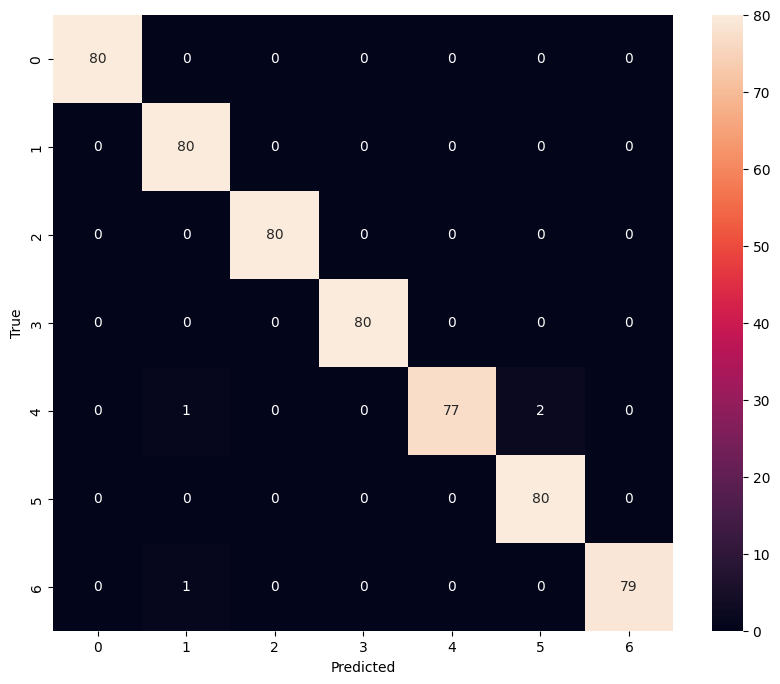

In [9]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {score[1]}")

# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sn.heatmap(confusion_mtx, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

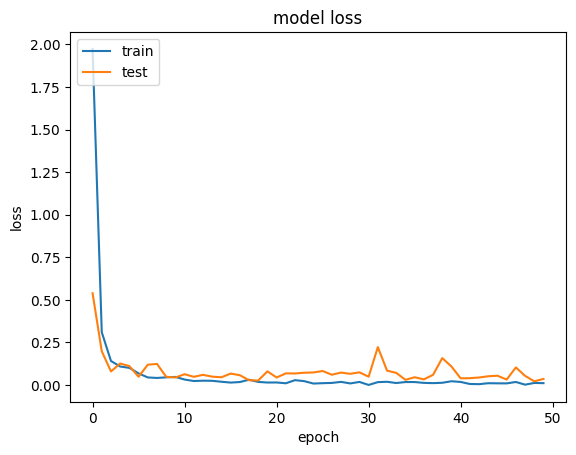

In [10]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

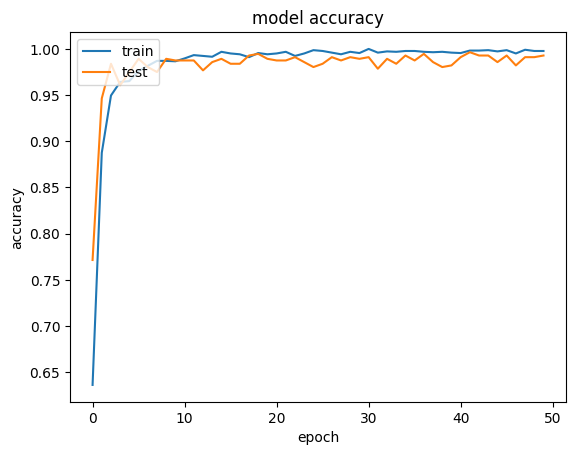

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [12]:
# Perform k-fold cross-validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the number of folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store accuracy for each fold
cv_accuracies = []

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    # Reshape data to fit the model: (num_samples, timesteps, num_features)
    X_train_cv = np.expand_dims(X_train_cv, axis=-1)
    X_val_cv = np.expand_dims(X_val_cv, axis=-1)

    # Initialize a new model for each fold
    model_cv = Sequential()

    model_cv.add(
        Conv1D(
            64,
            5,
            padding="same",
            input_shape=(X_train_cv.shape[1], X_train_cv.shape[2]),
        )
    )
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))
    model_cv.add(MaxPooling1D(pool_size=4))

    model_cv.add(Conv1D(128, 5, padding="same"))
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))
    model_cv.add(MaxPooling1D(pool_size=4))

    model_cv.add(Conv1D(256, 5, padding="same"))
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))

    model_cv.add(Flatten())

    model_cv.add(Dense(8))
    model_cv.add(Activation("softmax"))

    # Define a new RMSprop optimizer with a lower learning rate for each fold
    opt_cv = RMSprop(learning_rate=0.001)

    model_cv.compile(
        loss="sparse_categorical_crossentropy", optimizer=opt_cv, metrics=["accuracy"]
    )

    # Train the model
    model_cv.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, verbose=1)

    # Evaluate the model on validation data
    y_val_pred = model_cv.predict(X_val_cv)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    accuracy = accuracy_score(y_val_cv, y_val_pred_classes)
    cv_accuracies.append(accuracy)

# Print cross-validation accuracies and mean accuracy
print(f"Cross-validation accuracies: {cv_accuracies}")
print(f"Mean cross-validation accuracy: {np.mean(cv_accuracies)}")

Epoch 1/50


c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4730 - loss: 3.9785
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9053 - loss: 0.2735
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9470 - loss: 0.1672
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9717 - loss: 0.0964
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9745 - loss: 0.0884
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9859 - loss: 0.0459
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9849 - loss: 0.0412
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9878 - loss: 0.0339
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9848 - loss: 0.0451
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9860 - loss: 0.0381
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9914 - loss: 0.0389
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9908 - loss: 0.

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4839 - loss: 3.5731
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9016 - loss: 0.2917
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9372 - loss: 0.2120
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9640 - loss: 0.1244
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9678 - loss: 0.0937
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9781 - loss: 0.0624
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9789 - loss: 0.0654
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9881 - loss: 0.0404
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9882 - loss: 0.0514
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9838 - loss: 0.0401
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9867 - loss: 0.0414
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5070 - loss: 3.3190
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8906 - loss: 0.3304
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9440 - loss: 0.1799
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9572 - loss: 0.1276
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9690 - loss: 0.0888
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9826 - loss: 0.0510
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9809 - loss: 0.0536
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9744 - loss: 0.0694
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9901 - loss: 0.0366
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9963 - loss: 0.0137
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9927 - loss: 0.0284
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy:

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4593 - loss: 4.6072
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8870 - loss: 0.3454
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9459 - loss: 0.1736
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9682 - loss: 0.1020
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9722 - loss: 0.0729
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9753 - loss: 0.0720
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9764 - loss: 0.0850
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9909 - loss: 0.0304
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9955 - loss: 0.0238
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9922 - loss: 0.0339
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9887 - loss: 0.0410
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9949 - lo

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4826 - loss: 3.9316
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8791 - loss: 0.3677
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9487 - loss: 0.1573
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9674 - loss: 0.0937
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9721 - loss: 0.0766
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9865 - loss: 0.0450
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9828 - loss: 0.0504
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9825 - loss: 0.0386
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9860 - loss: 0.0428
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9953 - loss: 0.0160
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9914 - loss: 0.0222
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9922 - loss: 0.0354
